

# Ridge Regression and the Lasso

In [80]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings('ignore')

We will use the `sklearn` package in order to perform ridge regression and
the lasso. The main functions in this package that we care about are `Ridge()`, which can be used
to fit ridge regression models, and `Lasso()` which will fit lasso models. They also have cross-validated counterparts: `RidgeCV()` and `LassoCV()`. We'll use these a bit later.

Before proceeding, let's first ensure that the missing values have been removed from the data. 

In [81]:
df = pd.read_csv('Hitters.csv')

In [82]:
df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,nan,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.00,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.00,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.00,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.50,N


In [83]:
df.shape

(322, 21)

In [46]:
df.isna().sum()

Unnamed: 0     0
AtBat          0
Hits           0
HmRun          0
Runs           0
RBI            0
Walks          0
Years          0
CAtBat         0
CHits          0
CHmRun         0
CRuns          0
CRBI           0
CWalks         0
League         0
Division       0
PutOuts        0
Assists        0
Errors         0
Salary        59
NewLeague      0
dtype: int64

In [47]:
df = pd.read_csv('Hitters.csv').dropna().drop('Unnamed: 0', axis = 1)
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [48]:
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


We will now perform ridge regression and the lasso in order to predict `Salary` on
the `Hitters` data. Let's set up our data:

In [49]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1)

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
AtBat          263 non-null int64
Hits           263 non-null int64
HmRun          263 non-null int64
Runs           263 non-null int64
RBI            263 non-null int64
Walks          263 non-null int64
Years          263 non-null int64
CAtBat         263 non-null int64
CHits          263 non-null int64
CHmRun         263 non-null int64
CRuns          263 non-null int64
CRBI           263 non-null int64
CWalks         263 non-null int64
PutOuts        263 non-null int64
Assists        263 non-null int64
Errors         263 non-null int64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: int64(16), uint8(3)
memory usage: 35.7 KB


# 6.6.1 Ridge Regression
The `Ridge()` function has an alpha argument that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially
covering the full range of scenarios from the null model containing
only the intercept, to the least squares fit:

In [50]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

Associated with each alpha value is a vector of ridge regression coefficients, which we'll
store in a matrix `coefs`. In this case, it is a $19 \times 100$
matrix, with 19 rows (one for each predictor) and 100
columns (one for each value of alpha). Remember that we'll want to standardize the
variables so that they are on the same scale. To do this, we can use the
`normalize = True` parameter:

In [52]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)
print(coefs)

[array([ 2.41792033e-10,  8.77087820e-10,  3.53418911e-09,  1.48322166e-09,
        1.56674826e-09,  1.84396625e-09,  7.54102361e-09,  2.07601888e-11,
        7.64034224e-11,  5.76187223e-10,  1.53282320e-10,  1.58190714e-10,
        1.67364484e-10,  9.68457013e-11,  1.58184041e-11, -7.37555427e-11,
       -2.57640933e-09, -3.46788982e-08, -5.11835167e-10]), array([ 3.19634838e-10,  1.15945848e-09,  4.67199001e-09,  1.96073175e-09,
        2.07114900e-09,  2.43761486e-09,  9.96878940e-09,  2.74437478e-11,
        1.01000828e-10,  7.61685599e-10,  2.02630206e-10,  2.09118814e-10,
        2.21245998e-10,  1.28024318e-10,  2.09109993e-11, -9.75004868e-11,
       -3.40586150e-09, -4.58434625e-08, -6.76615963e-10]), array([ 4.22538444e-10,  1.53273587e-09,  6.17609583e-09,  2.59197198e-09,
        2.73793708e-09,  3.22238339e-09,  1.31781529e-08,  3.62790194e-11,
        1.33517150e-10,  1.00690354e-09,  2.67865207e-10,  2.76442765e-10,
        2.92474189e-10,  1.69240613e-10,  2.76431104e-

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,
when a large value of alpha is used, as compared to when a small value of alpha is
used. Let's plot and find out:

Text(0, 0.5, 'weights')

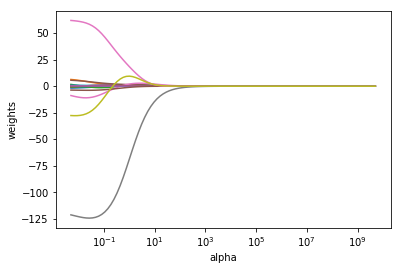

In [56]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso:

In [59]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

Next we fit a ridge regression model on the training set, and evaluate
its MSE on the test set, using $\lambda = 4$:

In [60]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

AtBat                         0.10
Hits                          0.45
HmRun                         1.41
Runs                          0.66
RBI                           0.84
Walks                         1.01
Years                         2.78
CAtBat                        0.01
CHits                         0.03
CHmRun                        0.27
CRuns                         0.07
CRBI                          0.07
CWalks                        0.08
PutOuts                       0.10
Assists                      -0.00
Errors                        0.27
League_N                      4.24
Division_W                  -30.77
NewLeague_N                   4.12
dtype: float64
106216.52238005563


The test MSE when alpha = 4 is 106216. Now let's see what happens if we use a huge value of alpha, say $10^{10}$:

In [61]:
ridge3 = Ridge(alpha = 10**10, normalize = True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))          # Calculate the test MSE

AtBat                         0.00
Hits                          0.00
HmRun                         0.00
Runs                          0.00
RBI                           0.00
Walks                         0.00
Years                         0.00
CAtBat                        0.00
CHits                         0.00
CHmRun                        0.00
CRuns                         0.00
CRBI                          0.00
CWalks                        0.00
PutOuts                       0.00
Assists                      -0.00
Errors                        0.00
League_N                     -0.00
Division_W                   -0.00
NewLeague_N                  -0.00
dtype: float64
172862.23580379886


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test
MSE than fitting a model with just an intercept. We now check whether
there is any benefit to performing ridge regression with alpha = 4 instead of
just performing least squares regression. Recall that least squares is simply
ridge regression with alpha = 0.

In [62]:
ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE

AtBat                        -1.82
Hits                          4.26
HmRun                        -4.77
Runs                         -0.04
RBI                           3.98
Walks                         3.47
Years                         9.50
CAtBat                       -0.61
CHits                         2.17
CHmRun                        2.98
CRuns                         0.27
CRBI                         -0.60
CWalks                        0.17
PutOuts                       0.42
Assists                       0.46
Errors                       -6.02
League_N                    133.74
Division_W                 -113.74
NewLeague_N                 -81.93
dtype: float64
116690.4685666044


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha $ = 4$, it would be better to
use cross-validation to choose the tuning parameter alpha. We can do this using
the cross-validated ridge regression function, `RidgeCV()`. By default, the function
performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the
argument `cv`.

In [63]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.5748784976988678

Therefore, we see that the value of alpha that results in the smallest cross-validation
error is 0.57. What is the test MSE associated with this value of
alpha?

In [84]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

99825.64896292728

This represents a further improvement over the test MSE that we got using
alpha $ = 4$. Finally, we refit our ridge regression model on the full data set,
using the value of alpha chosen by cross-validation, and examine the coefficient
estimates.

In [65]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

AtBat                         0.06
Hits                          0.93
HmRun                         0.37
Runs                          1.09
RBI                           0.88
Walks                         1.72
Years                         0.78
CAtBat                        0.01
CHits                         0.06
CHmRun                        0.43
CRuns                         0.12
CRBI                          0.13
CWalks                        0.04
PutOuts                       0.18
Assists                       0.04
Errors                       -1.60
League_N                     24.77
Division_W                  -85.95
NewLeague_N                   8.34
dtype: float64

As expected, none of the coefficients are exactly zero - ridge regression does not
perform variable selection!

# 6.6.2 The Lasso
We saw that ridge regression with a wise choice of alpha can outperform least
squares as well as the null model on the Hitters data set. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we'll
use the `Lasso()` function; however, this time let us include the argument `max_iter = 10000`.
Other than that change, we proceed just as we did in fitting a ridge model:

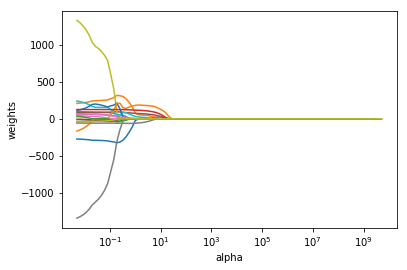

In [77]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights');

We now perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [78]:
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

104960.65853895503

This is substantially lower than the test set MSE of the null model and of
least squares, and only a little worse than the test MSE of ridge regression with alpha
chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 13 of
the 19 coefficient estimates are exactly zero: